# Data Pipeline

1. Load and process CSV files published on https://data.gov.sg/collections/189/view.
2. Load any existing geocoded addresses.
3. Update geocoded addresses.
4. Make H3 geometries.
5. Output data to disk for further downstream analytics.

In [1]:
import sys
sys.dont_write_bytecode = True

import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas

import h3
import matplotlib.pyplot as plt
import contextily as cx

# Local imports.
from resale_flat_prices.csv_data.csv_data import CsvData
from resale_flat_prices.geocode.geocoded_addresses import GeocodedAddresses


# Data directories.
csv_data_dir = Path("../data/ResaleFlatPrices/")
processed_data_dir = Path("../data/processed_data/")

In [2]:
csv_data = CsvData(csv_data_dir, wanted_columns="default")
csv_data.load_csv_files()
csv_data.compile_csv_data()
csv_data.process_csv_data()

print(type(csv_data.df), csv_data.df.shape)

<class 'geopandas.geodataframe.GeoDataFrame'> (939416, 19)


In [3]:
geocoded_addresses = GeocodedAddresses()
geocoded_addresses.read_json(processed_data_dir / "geocoded_addresses.json")

In [4]:
all_unique_addresses = set(csv_data.df["address"].unique())
all_unique_geocoded_addresses = geocoded_addresses.get_all_geocoded_addresses()

missing_addresses = all_unique_addresses.difference(all_unique_geocoded_addresses)
print(len(missing_addresses))

problem_addresses = geocoded_addresses.verify_geocoded_latitudes_and_longitudes(country="SINGAPORE")
print(len(problem_addresses))

0
0


In [5]:
right_df = geocoded_addresses.make_h3_geometries(resolution = 8, crs = "EPSG:4326")
left_df = csv_data.get_df()

df = pd.merge(left = left_df, right = right_df, left_on = "address", right_on = "address", how = "left")
df = geopandas.GeoDataFrame(df, crs = right_df.crs)

print(type(df), df.shape)

<class 'geopandas.geodataframe.GeoDataFrame'> (939416, 23)


In [9]:
#df.head()
df["town"].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN', 'LIM CHU KANG'], dtype=object)

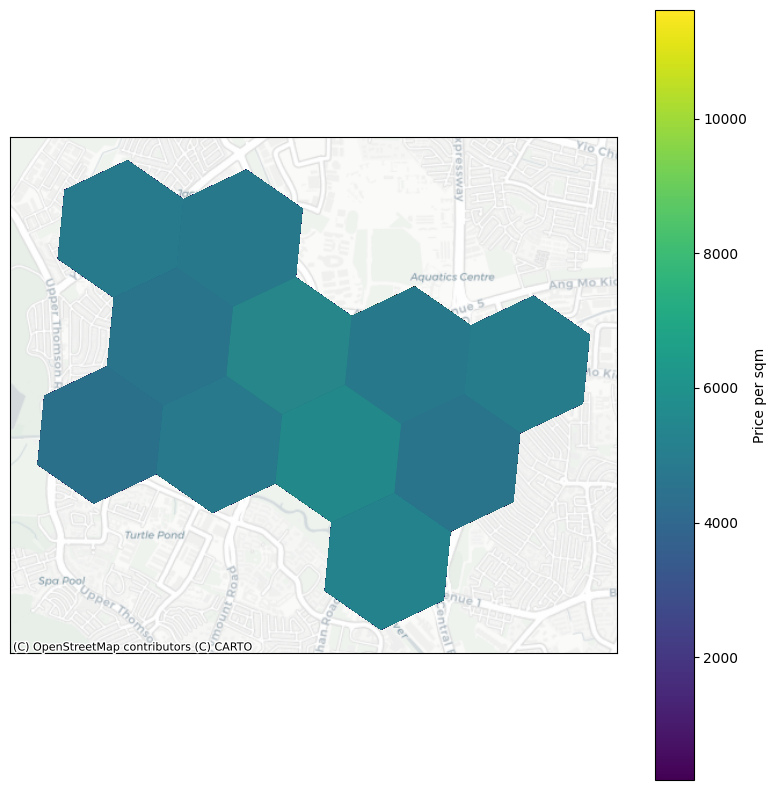

In [21]:
figsize = [8, 8]
fig, ax = plt.subplots(figsize = figsize)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

df[df["town"] == "ANG MO KIO"].plot(
    ax = ax,
    alpha = 0.333, 
    column = "price_per_sqm", 
    categorical = False,
    legend = True, 
    legend_kwds = {'label': "Price per sqm"},
)

cx.add_basemap(ax, crs = df.crs, source = cx.providers.CartoDB.Positron)
fig.tight_layout()
plt.show()